# Convolutional Neural Networks Part 2:

 - Methods To Handle Overfitting

### Transfer Learning With Pre-Trained Models: Fine Tuning VGG16 on CIFAR-10:

 - https://keras.io/api/applications/
     - https://www.image-net.org/
 - https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

#### Turn Off Messages & Set GPU Memory Growth:

In [17]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#### Check GPU Availibility & Set Memory Limit:

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]) # Alt: 1792 MB, 2048 MB
    except RuntimeError as e:
        print(e)

tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Import Libraries:

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import randint
from tensorflow.keras import layers, regularizers
from keras.models import Sequential, load_model, Model
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.layers import Dense, Conv2D, Flatten, Dropout, Activation, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

#### Define Functions For Plotting:

In [4]:
def plotBothCurves(trainingAccuracy, trainingLoss, validAccuracy, validLoss):
    epochs = np.arange(trainingLoss.shape[0])
    epochsSaved = np.arange(validLoss.shape[0])
    #print(epochs)
    # 1st Subplot: Accuracy
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    plt.plot(epochsSaved, validAccuracy) # Saved Best Value
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    # 2nd Subplot: Training Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.plot(epochsSaved, validLoss)
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

# Plot CIFAR-10 Data In Subplots
def img_plt(img, label):
    plt.figure(figsize=(12, 5.5))
    for i in range (1, 11):
        plt.subplot(2, 5, i)
        plt.imshow(img[i - 1, :, :], cmap = 'gray')
        plt.title('Label: ' + str(label[i - 1]))
    plt.show()

def plotEverything(model_hist):
    trainAcc = np.array(model_hist.history['accuracy'])
    trainLoss = np.array(model_hist.history['loss'])
    validAcc = np.array(model_hist.history['val_accuracy'])
    validLoss = np.array(model_hist.history['val_loss'])

    plotBothCurves(trainAcc, trainLoss, validAcc, validLoss)

    trainScore = [trainAcc[-1], trainLoss[-1]]
    print(f'\nTraining Accuracy: {round(trainScore[0], 5) * 100} %')
    print(f'Training Loss: {round(trainScore[1], 4)}\n')

    valScore = [validAcc[-1], validLoss[-1]]
    print(f'\nValidation Accuracy: {round(valScore[0], 5) * 100} %')
    print(f'Validation Loss: {round(valScore[1], 4)}\n')

#### Import Data:

 - Each of the 50,000 Images is 32 x 32 pixels x 3 RGB values
     - Each Image is 3D.

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

classes = np.arange(10)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


#### Randomize & Select 20% of Images For Validation:

In [6]:
num_train_img = x_train.shape[0]
train_ind = np.arange(0, num_train_img)
train_ind_s = np.random.permutation(train_ind)
print(train_ind)
print(train_ind_s, '\n')

x_train = x_train[train_ind_s,:,:,:]
y_train = y_train[train_ind_s]
print(x_train.shape)
print(y_train.shape, '\n')

x_val = x_train[0:int(0.2 * num_train_img),:,:,:]
y_val = y_train[0:int(0.2 * num_train_img)]
print(x_val.shape)
print(y_val.shape, '\n')

x_train = x_train[int(0.2 * num_train_img):,:,:]
y_train = y_train[int(0.2 * num_train_img):]
print(x_train.shape)
print(y_train.shape, '\n')

[    0     1     2 ... 49997 49998 49999]
[35835  3830  1046 ... 13667 21689 22438] 

(50000, 32, 32, 3)
(50000, 1) 

(10000, 32, 32, 3)
(10000, 1) 

(40000, 32, 32, 3)
(40000, 1) 



#### Plot 1st 10 Images From Randomized Data:

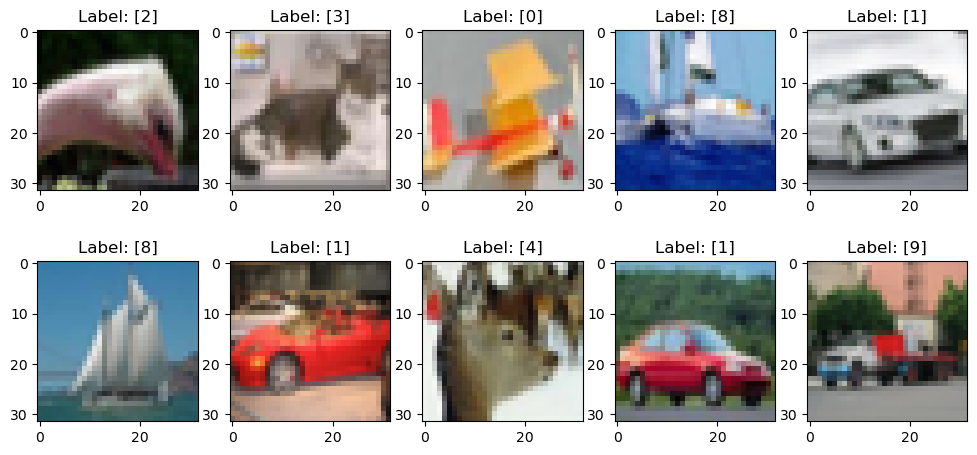

In [7]:
img_plt(x_train[0:10,:,:,:], y_train[0:10]) # plot the images

#### Preprocess Images For VGG16:

 - Scale Data According to Pre-Trained VGG-16 Model

In [8]:
x_train_vgg = preprocess_input(x_train)
x_val_vgg = preprocess_input(x_val)
x_test_vgg = preprocess_input(x_test)

#### Convert Class Vectors to Binary Class Matrices:

In [9]:
y_train_c = to_categorical(y_train, len(classes))
y_val_c = to_categorical(y_val, len(classes))
y_test_c = to_categorical(y_test, len(classes))

#### Load VGG16 Model Without Classifier Layers:

In [10]:
model7 = VGG16(include_top=False, input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), weights='imagenet')
#model7.summary()

# To Load The Model *with* classifier layers:
# model7 = VGG16(include_top=True, weights='imagenet')
# model7.summary()

# Fine Tune From This Layer Onwards:
fine_tune_at = 15

# Print Layer Numbers:
for i, layer in enumerate(model7.layers):
    print(f'Layer {str(i)} : {model7.layers[i].name}')

# Mark Loaded Layers As Not Trainable:
print(f'\n\nThe model weights starting at layer ({ model7.layers[fine_tune_at].name }) will be fine tuned\n')
for layer in model7.layers[:fine_tune_at]:
    layer.trainable = False

Layer 0 : input_1
Layer 1 : block1_conv1
Layer 2 : block1_conv2
Layer 3 : block1_pool
Layer 4 : block2_conv1
Layer 5 : block2_conv2
Layer 6 : block2_pool
Layer 7 : block3_conv1
Layer 8 : block3_conv2
Layer 9 : block3_conv3
Layer 10 : block3_pool
Layer 11 : block4_conv1
Layer 12 : block4_conv2
Layer 13 : block4_conv3
Layer 14 : block4_pool
Layer 15 : block5_conv1
Layer 16 : block5_conv2
Layer 17 : block5_conv3
Layer 18 : block5_pool


The model weights starting at layer (block5_conv1) will be fine tuned



#### Add New Classifier Layers & Define The New Model:

In [11]:
flat1 = Flatten()(model7.outputs[0])
fc1 = Dense(1024, activation='relu')(flat1)
fc1 = Dropout(0.2)(fc1)
fc2 = Dense(512, activation='relu')(fc1)
fc2 = Dropout(0.2)(fc2)
output = Dense(len(classes), activation='softmax')(fc2)

model7 = Model(inputs=model7.inputs, outputs=output)
model7.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

#### Compile The Model & Create Image Data Generator:

In [12]:
savePath7 = '../assets/Lecture7/model7_ckpt.h5'
callbacksSave7 = ModelCheckpoint(savePath7, monitor='val_loss', verbose=0, save_best_only=True, save_freq='epoch')

opt7 = tf.keras.optimizers.Adam(learning_rate=0.0001)
model7.compile(loss='categorical_crossentropy', optimizer=opt7, metrics = ['accuracy'])

datagen7 = ImageDataGenerator(
    #shear_range = -0.1,
    #zoom_range = -0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Compute Values required for featurewize normalization
# (std, mean, principle components)
datagen7.fit(x_train_vgg)

#### Fit The Model On Batches With Real-Time Data Augmentation:

Epoch 1/20
2500/2500 [==============================] - 244s 95ms/step - loss: 1.7540 - accuracy: 0.4175 - val_loss: 0.8065 - val_accuracy: 0.7322
Epoch 2/20
2500/2500 [==============================] - 235s 94ms/step - loss: 0.8460 - accuracy: 0.7142 - val_loss: 0.7374 - val_accuracy: 0.7521
Epoch 3/20
2500/2500 [==============================] - 239s 95ms/step - loss: 0.7494 - accuracy: 0.7464 - val_loss: 0.7241 - val_accuracy: 0.7571
Epoch 4/20
2500/2500 [==============================] - 236s 94ms/step - loss: 0.6850 - accuracy: 0.7694 - val_loss: 0.6512 - val_accuracy: 0.7811
Epoch 5/20
2500/2500 [==============================] - 140s 56ms/step - loss: 0.6253 - accuracy: 0.7870 - val_loss: 0.6319 - val_accuracy: 0.7913
Epoch 6/20
2500/2500 [==============================] - 78s 31ms/step - loss: 0.5772 - accuracy: 0.8052 - val_loss: 0.6265 - val_accuracy: 0.7914
Epoch 7/20
2500/2500 [==============================] - 78s 31ms/step - loss: 0.5416 - accuracy: 0.8119 - val_loss: 0.5

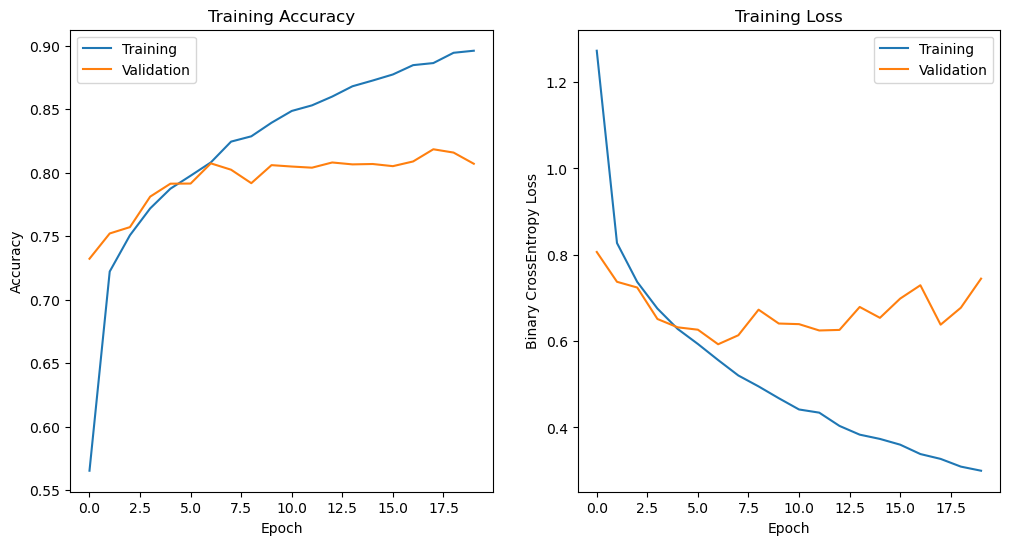


Training Accuracy: 89.60000000000001 %
Training Loss: 0.2998


Validation Accuracy: 80.7 %
Validation Loss: 0.7447



In [13]:
history7 = model7.fit(datagen7.flow(x_train_vgg, y_train_c, batch_size=16),
                      steps_per_epoch=len(x_train) / 16, epochs=20, verbose=1, 
                      validation_data=(x_val_vgg, y_val_c), callbacks=callbacksSave7)

plotEverything(history7)

#### Load Best Model & Evaluate On Training Samples:

In [ ]:
model7a = load_model(savePath7)

score7a = model7a.evaluate(x_train_vgg, y_train_c)
print(f'Total Loss From Training Set: {score7a[0]}')
print(f'Accuracy From Training Set: {score7a[1] * 100} %\n')

score7b = model7a.evaluate(x_val_vgg, y_val_c)
print(f'Total Loss From Validation Set: {score7b[0]}')
print(f'Accuracy From Validation Set: {score7b[1] * 100} %\n')

score7c = model7a.evaluate(x_test, y_test_c)
print(f'Total Loss From Testing Set: {score7c[0]}')
print(f'Accuracy From Testing Set: {score7c[1] * 100} %\n')

#### Predict Class Of Held Out Samples:

In [ ]:
test_class4_prob = model7.predict(x_test)
test_labels4 = np.argmax(test_class4_prob, axis=1)
print(f'The Accuracy Predicting The Test Set is: {accuracy_score(test_labels4, y_test) * 100} %\n')
conf_matrix4 = confusion_matrix(test_labels4, y_test)

colLabels4 = ['Pred Plane', 'Pred Car', 'Pred Bird', 'Pred Cat', 'Pred Deer',
             'Pred Dog', 'Pred Frog', 'Pred Horse', 'Pred Ship', 'Pred Truck']
rowLabels4 = ['Actual Plane', 'Actual Car', 'Actual Bird', 'Actual Cat', 'Actual Deer',
             'Actual Dog', 'Actual Frog', 'Actual Horse', 'Actual Ship', 'Actual Truck']

fancyMatrix4 = pd.DataFrame(conf_matrix4, columns=colLabels4, index=rowLabels4,)
display(fancyMatrix4)